Note: the css style for this notebook lives in `~/.jupyter/custom/custom.css`.

# Purpose of notebook
I want to try out here a very simple definition of motion energy for the random dots stimulus.

I will first test this definition with 1D stimuli, and if things work out well, I'll move on to 2D stimuli.

**Notation:** Capital letter are usually reserved for vectors, whereas lower-case letters are used to denote entries within a vector. So $A=(a_i)_{1\leq i\leq n}$ for instance.

# One-dimensional stimulus
Consider a 1D grid with $N$ contiguous cells. I index time with the letter $t$. Time is discrete here and starts at 0.
## State vectors
Let $X(t)$ denote the state vector of the system at time $t$. The entries $x_i(t), 1\leq i \leq N$ of this vector contain the particle count of cell $i$.

Numerically, with 1D space, the whole "movie" can be stored in a $T+1$-by-$N$ matrix.
## Displacement vectors
Given two consecutive time steps, we define the displacement vector $\dot{X}(t):=X(t)-X(t-1)$ as the difference between the two consecutive state vectors.

If $0\leq t\leq T\in \mathbb{N}$, then $\dot{X}(t)$ may *only* be computed for $1\leq t \leq T$.

As for the state vectors. Stacking displacement row vectors on top of each other yields a *displacement matrix*.
## Movement vectors
The movement vector $M(t)$ has $N-1$ entries defined as the "right space derivative" of the displacement vector, *only taken around existing particles*. This last remark is important, as it prevents movement from being perceived/recorded around cells whose state is stationary. We thus define the entries of the movement vector as follows: $m_n(t):=\dot{x}_n(t)-\dot{x}_{n-1}(t)$ if $\dot{x}_n(t)\dot{x}_{n-1}(t)\neq 0$, and $0$ otherwise $(2\leq n \leq N, 1\leq t\leq T)$. 

Intuitively, a positive $m_i(t)$ is interpreted as rightward _movement_ between cells $i-1$ and $i$, in the time step $t-1 \to t$. Similarly, a negative entry is interpreted as leftward movement. Finally, the magnitude of the entry $|m_i(t)|$ is interpreted as the "strength" of the movement.

As for the state vectors. Stacking movement row vectors on top of each other yields a *movement matrix*.
## Motion Energy (custom definition)
I propose to define motion energy locally in time as follows.
$$ME(t):=\sum_{n=2}^N m_n(t),\qquad \forall 1\leq t\leq T$$
## Some examples

In [54]:
from ME_functions import *

In [55]:
# Fix grid size and time horizon
N = 10; T = 20;

### Single particle moving rightward

In [56]:
# create state matrix
stateMatrix = np.zeros((T+1,N),dtype=int)

for t in range(T+1):
    particleState = np.mod(t,N) # particle wraps around when hitting right boundary
    stateMatrix[t,particleState] = 1

In [57]:
stateMatrix.shape[1]

10

state matrix
 [[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]]
displacement matrix
 [[-1  1  0  0  0  0  0  0  0  0]
 [ 0 -1  1  0  0  0  0  0  0  0]
 [ 0  0 -1  1  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0  0  0]
 [ 0  0  0  0 -1  1  0  0  0  0]
 [ 0  0  0  0  0 -1  1  0  0  0]
 [ 0  0  0  0  0  0 -1  1  0  0]
 [ 0  0  0  0  0  0  0 -1  1  0]
 [ 0  0  0  0  0  0  0  0 -1  1]
 [ 1  0  0  0  0  0  0  0  0 -1]
 [-1  1  0  0  0  0  0  0  0  0]
 [ 0 -1  1  0  0  0  0  0  0  0]
 [ 0  0 -1  1  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0  0  0]
 [ 0  0  0  0 -1  1

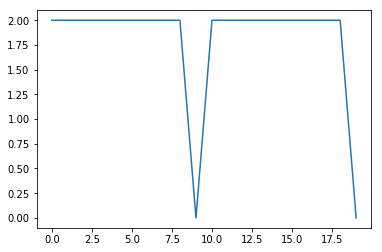

In [59]:
%matplotlib inline
plt.plot(custom_ME(stateMatrix))

1 20 0
<class 'numpy.ndarray'>
2 20 1
<class 'numpy.ndarray'>
3 20 2
<class 'numpy.ndarray'>


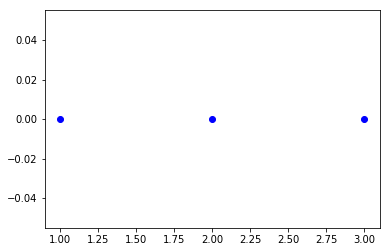

In [61]:
# DEBUG
x=np.arange(N)+1
scope=3
fig, ax = plt.subplots()
for t in np.arange(scope)+1:
    print(t,T,np.mod(t-1,T+1))
    xx=x[stateMatrix[np.mod(t-1,T+1),:].nonzero()]
    print(type(xx))
    ax.plot(xx, 0,'bo')

In [78]:
# DEBUG
duration = 1  # duration of clip in seconds
totFrames = T + 1 # visit each row of the state matrix once in the clip
frameRate = totFrames // duration
binSize = duration / totFrames
print(duration, totFrames, frameRate, binSize, int(np.floor(.2/binSize)))

1 21 21 0.047619047619047616 4









  0%|          | 0/21 [00:00<?, ?it/s]

state matrix
 [[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]]
displacement matrix
 [[-1  1  0  0  0  0  0  0  0  0]
 [ 0 -1  1  0  0  0  0  0  0  0]
 [ 0  0 -1  1  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0  0  0]
 [ 0  0  0  0 -1  1  0  0  0  0]
 [ 0  0  0  0  0 -1  1  0  0  0]
 [ 0  0  0  0  0  0 -1  1  0  0]
 [ 0  0  0  0  0  0  0 -1  1  0]
 [ 0  0  0  0  0  0  0  0 -1  1]
 [ 1  0  0  0  0  0  0  0  0 -1]
 [-1  1  0  0  0  0  0  0  0  0]
 [ 0 -1  1  0  0  0  0  0  0  0]
 [ 0  0 -1  1  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0  0  0]
 [ 0  0  0  0 -1  1








 10%|▉         | 2/21 [00:00<00:01, 11.43it/s]






 19%|█▉        | 4/21 [00:00<00:01, 11.65it/s]






 29%|██▊       | 6/21 [00:00<00:01, 11.79it/s]






 38%|███▊      | 8/21 [00:00<00:01, 11.85it/s]






 48%|████▊     | 10/21 [00:00<00:00, 11.86it/s]






 57%|█████▋    | 12/21 [00:01<00:00, 10.99it/s]






 62%|██████▏   | 13/21 [00:01<00:00, 10.02it/s]






 67%|██████▋   | 14/21 [00:01<00:00,  9.91it/s]






 76%|███████▌  | 16/21 [00:01<00:00, 10.42it/s]






 86%|████████▌ | 18/21 [00:01<00:00, 10.26it/s]






 95%|█████████▌| 20/21 [00:01<00:00, 10.46it/s]








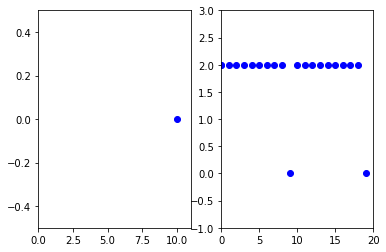

In [89]:
# example cell taken from here: https://zulko.github.io/moviepy/getting_started/working_with_matplotlib.html

x=np.arange(N)+1  # 1D space
ME = custom_ME(stateMatrix) # motion energy
ME_lb = np.min(ME)-1
ME_ub = np.max(ME)+1

duration = 2  # duration of clip in seconds
totFrames = T + 1 # visit each row of the state matrix once in the clip
frameRate = totFrames // duration
binSize = duration / totFrames

fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.clear()
ax2.set_xlim(0,T)
ax2.set_ylim(ME_lb, ME_ub)

animation = VideoClip(make_frame(t, ax1, ax2, stateMatrix, T, N, ME, fig), duration=duration)
animation.ipython_display(fps=frameRate, loop=True, autoplay=True)

### Two particles moving in opposite direction

In [92]:
# create state matrix
stateMatrix = np.zeros((T+1,N),dtype=int)

for t in range(T+1):
    particleState = np.mod(t,N) # particle wraps around when hitting right boundary
    stateMatrix[t,particleState] = 1
    stateMatrix[t,-particleState-1] = 1 # mirror particle

state matrix
 [[1 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1]]
displacement matrix
 [[-1  1  0  0  0  0  0  0  1 -1]
 [ 0 -1  1  0  0  0  0  1 -1  0]
 [ 0  0 -1  1  0  0  1 -1  0  0]
 [ 0  0  0 -1  1  1 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 -1 -1  1  0  0  0]
 [ 0  0  1 -1  0  0 -1  1  0  0]
 [ 0  1 -1  0  0  0  0 -1  1  0]
 [ 1 -1  0  0  0  0  0  0 -1  1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [-1  1  0  0  0  0  0  0  1 -1]
 [ 0 -1  1  0  0  0  0  1 -1  0]
 [ 0  0 -1  1  0  0  1 -1  0  0]
 [ 0  0  0 -1  1  1 -1  0  0  0]
 [ 0  0  0  0  0  0

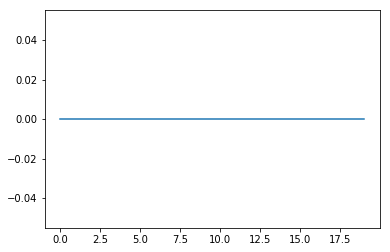

In [93]:
%matplotlib inline
plt.plot(custom_ME(stateMatrix))








  0%|          | 0/21 [00:00<?, ?it/s]

state matrix
 [[1 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1]]
displacement matrix
 [[-1  1  0  0  0  0  0  0  1 -1]
 [ 0 -1  1  0  0  0  0  1 -1  0]
 [ 0  0 -1  1  0  0  1 -1  0  0]
 [ 0  0  0 -1  1  1 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 -1 -1  1  0  0  0]
 [ 0  0  1 -1  0  0 -1  1  0  0]
 [ 0  1 -1  0  0  0  0 -1  1  0]
 [ 1 -1  0  0  0  0  0  0 -1  1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [-1  1  0  0  0  0  0  0  1 -1]
 [ 0 -1  1  0  0  0  0  1 -1  0]
 [ 0  0 -1  1  0  0  1 -1  0  0]
 [ 0  0  0 -1  1  1 -1  0  0  0]
 [ 0  0  0  0  0  0








  5%|▍         | 1/21 [00:00<00:02,  9.93it/s]






 14%|█▍        | 3/21 [00:00<00:01, 10.47it/s]






 24%|██▍       | 5/21 [00:00<00:01, 10.98it/s]






 33%|███▎      | 7/21 [00:00<00:01, 11.33it/s]






 43%|████▎     | 9/21 [00:00<00:01, 11.48it/s]






 52%|█████▏    | 11/21 [00:00<00:00, 11.55it/s]






 62%|██████▏   | 13/21 [00:01<00:00, 11.25it/s]






 71%|███████▏  | 15/21 [00:01<00:00, 11.23it/s]






 81%|████████  | 17/21 [00:01<00:00, 11.44it/s]






 90%|█████████ | 19/21 [00:01<00:00, 11.68it/s]






 95%|█████████▌| 20/21 [00:01<00:00, 11.52it/s]

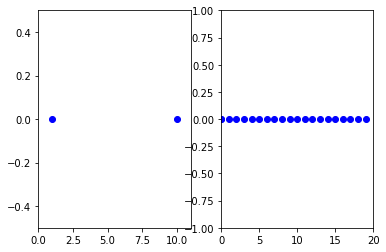

In [95]:
# example cell taken from here: https://zulko.github.io/moviepy/getting_started/working_with_matplotlib.html

x=np.arange(N)+1  # 1D space
ME = custom_ME(stateMatrix) # motion energy
ME_lb = np.min(ME)-1
ME_ub = np.max(ME)+1

duration = 2  # duration of clip in seconds
totFrames = T + 1 # visit each row of the state matrix once in the clip
frameRate = totFrames // duration
binSize = duration / totFrames

def map_time_to_frame(t):
    return int(np.floor(t/binSize))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.clear()
ax2.set_xlim(0,T)
ax2.set_ylim(ME_lb, ME_ub)
def make_frame(t):
    ax1.clear()
    tt = map_time_to_frame(t)
    xx=x[stateMatrix[np.mod(tt,T+1),:]==1]
    ax1.plot(xx, np.zeros(xx.shape), 'bo')
    ax1.set_ylim(-.5, 0.5)
    ax1.set_xlim(0, N+1)
    
    #ax2.clear()
    ax2.plot(tt,ME[tt],'bo')

    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=frameRate, loop=True, autoplay=True)

### Two particles moving in same direction

In [101]:
# create state matrix
stateMatrix = np.zeros((T+1,N),dtype=int)
offset = 3
for t in range(T+1):
    particle1_State = np.mod(t,N) # particle wraps around when hitting right boundary
    particle2_State = np.mod(t+offset,N) # particle wraps around when hitting right boundary
    stateMatrix[t,particle1_State] = 1
    stateMatrix[t,particle2_State] = 1 # mirror particle

state matrix
 [[1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 1]
 [1 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 1]
 [1 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 0 0 0 0 0 0]]
displacement matrix
 [[-1  1  0 -1  1  0  0  0  0  0]
 [ 0 -1  1  0 -1  1  0  0  0  0]
 [ 0  0 -1  1  0 -1  1  0  0  0]
 [ 0  0  0 -1  1  0 -1  1  0  0]
 [ 0  0  0  0 -1  1  0 -1  1  0]
 [ 0  0  0  0  0 -1  1  0 -1  1]
 [ 1  0  0  0  0  0 -1  1  0 -1]
 [-1  1  0  0  0  0  0 -1  1  0]
 [ 0 -1  1  0  0  0  0  0 -1  1]
 [ 1  0 -1  1  0  0  0  0  0 -1]
 [-1  1  0 -1  1  0  0  0  0  0]
 [ 0 -1  1  0 -1  1  0  0  0  0]
 [ 0  0 -1  1  0 -1  1  0  0  0]
 [ 0  0  0 -1  1  0 -1  1  0  0]
 [ 0  0  0  0 -1  1

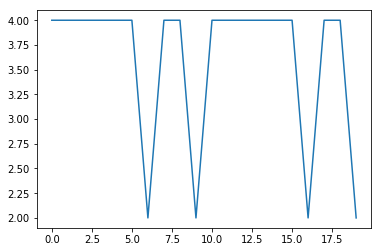

In [102]:
%matplotlib inline
plt.plot(custom_ME(stateMatrix))

state matrix
 [[1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 1]
 [1 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 1]
 [1 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 0 0 0 0 0 0]]
displacement matrix
 [[-1  1  0 -1  1  0  0  0  0  0]
 [ 0 -1  1  0 -1  1  0  0  0  0]
 [ 0  0 -1  1  0 -1  1  0  0  0]
 [ 0  0  0 -1  1  0 -1  1  0  0]
 [ 0  0  0  0 -1  1  0 -1  1  0]
 [ 0  0  0  0  0 -1  1  0 -1  1]
 [ 1  0  0  0  0  0 -1  1  0 -1]
 [-1  1  0  0  0  0  0 -1  1  0]
 [ 0 -1  1  0  0  0  0  0 -1  1]
 [ 1  0 -1  1  0  0  0  0  0 -1]
 [-1  1  0 -1  1  0  0  0  0  0]
 [ 0 -1  1  0 -1  1  0  0  0  0]
 [ 0  0 -1  1  0 -1  1  0  0  0]
 [ 0  0  0 -1  1  0 -1  1  0  0]
 [ 0  0  0  0 -1  1








  0%|          | 0/21 [00:00<?, ?it/s]






  5%|▍         | 1/21 [00:00<00:03,  5.52it/s]






 10%|▉         | 2/21 [00:00<00:03,  5.85it/s]






 14%|█▍        | 3/21 [00:00<00:02,  6.07it/s]






 19%|█▉        | 4/21 [00:00<00:02,  6.40it/s]






 24%|██▍       | 5/21 [00:00<00:02,  6.05it/s]






 29%|██▊       | 6/21 [00:00<00:02,  6.11it/s]






 33%|███▎      | 7/21 [00:01<00:02,  6.44it/s]






 38%|███▊      | 8/21 [00:01<00:01,  6.65it/s]






 43%|████▎     | 9/21 [00:01<00:01,  6.77it/s]






 48%|████▊     | 10/21 [00:01<00:01,  6.72it/s]






 52%|█████▏    | 11/21 [00:01<00:01,  6.85it/s]






 57%|█████▋    | 12/21 [00:01<00:01,  6.93it/s]






 62%|██████▏   | 13/21 [00:01<00:01,  7.03it/s]






 67%|██████▋   | 14/21 [00:02<00:00,  7.02it/s]






 71%|███████▏  | 15/21 [00:02<00:00,  6.64it/s]






 76%|███████▌  | 16/21 [00:02<00:00,  6.63it/s]






 81%|████████  | 17/21 [00:02<00:00,  6.76it/s]






 86%|████████▌ | 18/21 [00:02<00:00,  6

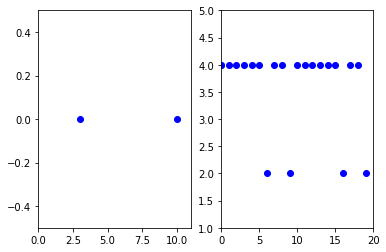

In [103]:
# example cell taken from here: https://zulko.github.io/moviepy/getting_started/working_with_matplotlib.html

x=np.arange(N)+1  # 1D space
ME = custom_ME(stateMatrix) # motion energy
ME_lb = np.min(ME)-1
ME_ub = np.max(ME)+1

duration = 2  # duration of clip in seconds
totFrames = T + 1 # visit each row of the state matrix once in the clip
frameRate = totFrames // duration
binSize = duration / totFrames

def map_time_to_frame(t):
    return int(np.floor(t/binSize))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.clear()
ax2.set_xlim(0,T)
ax2.set_ylim(ME_lb, ME_ub)
def make_frame(t):
    ax1.clear()
    tt = map_time_to_frame(t)
    xx=x[stateMatrix[np.mod(tt,T+1),:]==1]
    ax1.plot(xx, np.zeros(xx.shape), 'bo')
    ax1.set_ylim(-.5, 0.5)
    ax1.set_xlim(0, N+1)
    
    #ax2.clear()
    ax2.plot(tt,ME[tt],'bo')

    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=frameRate, loop=True, autoplay=True)